### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [54]:


import scipy.stats as stats
import os
import math

from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


In [80]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = ''' 
        
        Select *, f.title as film_title, sum(p.amount) as total_sales
        from payment p
        join rental r
        on p.rental_id = r.rental_id 
        join inventory i 
        on r.inventory_id = i.inventory_id
        join film f 
        on i.film_id = f.film_id 
        group by f.title
        order by total_sales desc;
        '''

data = pd.read_sql_query(query, engine)
data

,payment_id,customer_id,staff_id,rental_id,amount,payment_date,last_update,rental_id,rental_date,inventory_id,...,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,film_title,total_sales
0,7017,260,1,2091,10.99,2005-06-17 18:09:04,2006-02-15 22:14:58,2091,2005-06-17 18:09:04,4033,...,None,3,4.99,148,20.99,PG,Commentaries,2006-02-15 05:03:42,TELEGRAPH VOYAGE,231.73
1,3833,142,1,575,9.99,2005-05-28 10:56:09,2006-02-15 22:13:23,575,2005-05-28 10:56:09,4451,...,None,3,4.99,183,27.99,NC-17,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,WIFE TURN,223.69
2,4302,158,2,6901,5.99,2005-07-12 21:46:33,2006-02-15 22:13:34,6901,2005-07-12 21:46:33,4574,...,None,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",2006-02-15 05:03:42,ZORRO ARK,214.69
3,7708,285,2,1161,7.99,2005-06-14 23:07:08,2006-02-15 22:15:25,1161,2005-06-14 23:07:08,1690,...,None,4,4.99,56,22.99,PG,Deleted Scenes,2006-02-15 05:03:42,GOODFELLAS SALUTE,209.69
4,1078,39,1,5451,4.99,2005-07-09 22:22:10,2006-02-15 22:12:38,5451,2005-07-09 22:22:10,3484,...,None,3,4.99,150,28.99,G,"Commentaries,Deleted Scenes",2006-02-15 05:03:42,SATURDAY LAMBS,204.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,11220,415,2,5665,0.99,2005-07-10 08:10:08,2006-02-15 22:18:13,5665,2005-07-10 08:10:08,1175,...,None,5,0.99,171,13.99,G,Commentaries,2006-02-15 05:03:42,DUFFEL APOCALYPSE,6.93
954,6226,231,2,4969,0.99,2005-07-08 23:51:26,2006-02-15 22:14:31,4969,2005-07-08 23:51:26,4563,...,None,6,0.99,183,9.99,G,"Trailers,Behind the Scenes",2006-02-15 05:03:42,YOUNG LANGUAGE,6.93
955,3904,144,2,9714,0.99,2005-07-31 08:15:32,2006-02-15 22:13:25,9714,2005-07-31 08:15:32,1532,...,None,5,0.99,133,23.99,PG-13,"Trailers,Commentaries,Behind the Scenes",2006-02-15 05:03:42,FREEDOM CLEOPATRA,5.95
956,15743,588,1,4101,0.99,2005-07-07 06:25:11,2006-02-15 22:22:59,4101,2005-07-07 06:25:11,2891,...,None,7,0.99,58,15.99,PG,Behind the Scenes,2006-02-15 05:03:42,OKLAHOMA JUMANJI,5.94


### 2- Read the data into a Pandas dataframe

In [81]:
pd.read_sql_table('sales_by_film', engine) 

,film_title,total_sales,activity_month
0,TELEGRAPH VOYAGE,231.73,06
1,WIFE TURN,223.69,05
2,ZORRO ARK,214.69,07
3,GOODFELLAS SALUTE,209.69,06
4,SATURDAY LAMBS,204.72,07
...,...,...,...
953,DUFFEL APOCALYPSE,6.93,07
954,YOUNG LANGUAGE,6.93,07
955,FREEDOM CLEOPATRA,5.95,07
956,OKLAHOMA JUMANJI,5.94,07


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [82]:
data.dtypes

payment_id                       int64
customer_id                      int64
staff_id                         int64
rental_id                        int64
amount                         float64
payment_date            datetime64[ns]
last_update             datetime64[ns]
rental_id                        int64
rental_date             datetime64[ns]
inventory_id                     int64
customer_id                      int64
return_date             datetime64[ns]
staff_id                         int64
last_update             datetime64[ns]
inventory_id                     int64
film_id                          int64
store_id                         int64
last_update             datetime64[ns]
film_id                          int64
title                           object
description                     object
release_year                     int64
language_id                      int64
original_language_id            object
rental_duration                  int64
rental_rate              

In [83]:
data.isna().sum()

payment_id                0
customer_id               0
staff_id                  0
rental_id                 0
amount                    0
payment_date              0
last_update               0
rental_id                 0
rental_date               0
inventory_id              0
customer_id               0
return_date               0
staff_id                  0
last_update               0
inventory_id              0
film_id                   0
store_id                  0
last_update               0
film_id                   0
title                     0
description               0
release_year              0
language_id               0
original_language_id    958
rental_duration           0
rental_rate               0
length                    0
replacement_cost          0
rating                    0
special_features          0
last_update               0
film_title                0
total_sales               0
dtype: int64

In [84]:
data['total_sales'] = data['total_sales'].astype('object') 

In [85]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

PULP BEVERLY          1
OUTBREAK DIVINE       1
MADIGAN DORADO        1
SMOKING BARBARELLA    1
PRIX UNDEFEATED       1
                     ..
NASH CHOCOLAT         1
BEAST HUNCHBACK       1
SATURN NAME           1
SAMURAI LION          1
MASK PEACH            1
Name: title, Length: 958, dtype: int64 

A Fateful Display of a Cat And a Pioneer who must Challenge a Pastry Chef in A Baloon Factory                                1
A Awe-Inspiring Documentary of a Technical Writer And a Husband who must Meet a Monkey in An Abandoned Fun House             1
A Awe-Inspiring Character Study of a Waitress And a Car who must Pursue a Mad Scientist in The First Manned Space Station    1
A Boring Display of a Moose And a Squirrel who must Outrace a Teacher in A Shark Tank                                        1
A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China                         1
                                                            

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [9]:
query2 = '''
        Select *
        from 'sales_by_film' , 
        group by film_title
        order by total_sales desc;
        '''

data = pd.read_sql_query(query2, engine)

ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near ''sales_by_film' , \n        group by film_title\n        order by total_sales desc' at line 2")
[SQL: 
        Select *
        from 'sales_by_film' , 
        group by film_title
        order by total_sales desc;
        ]
(Background on this error at: http://sqlalche.me/e/14/f405)

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [86]:
cat = data.select_dtypes('object')

In [87]:
y = data['total_sales']
X = data.drop(['total_sales'], axis=1)

In [88]:
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

In [89]:
transformer = Normalizer().fit(X_num)
x_normalized = transformer.transform(X_num)
print(x_normalized.shape)

(958, 19)


In [90]:
encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(X_cat)

OneHotEncoder(drop='first')

In [91]:
encoded = encoder.transform(X_cat).toarray()
encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

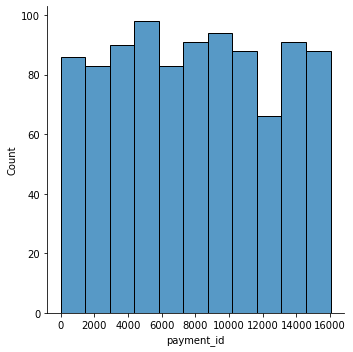

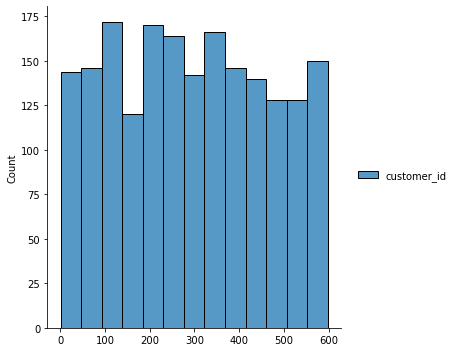

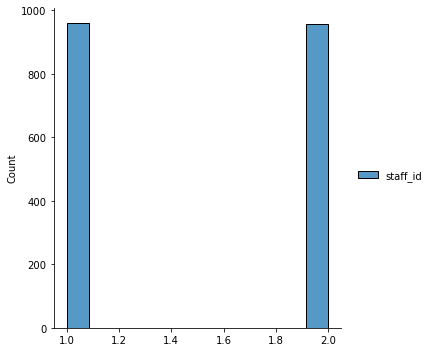

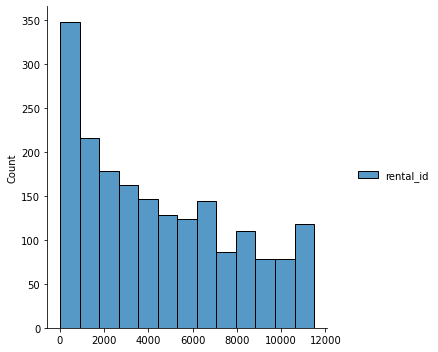

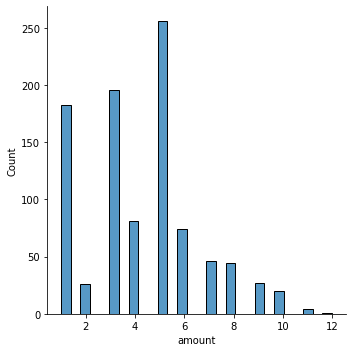

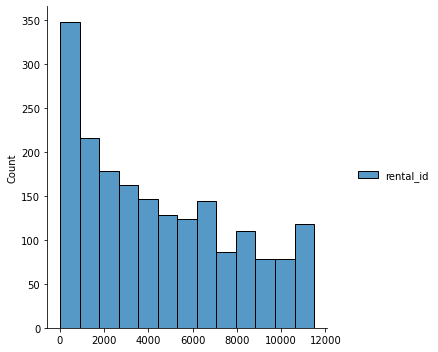

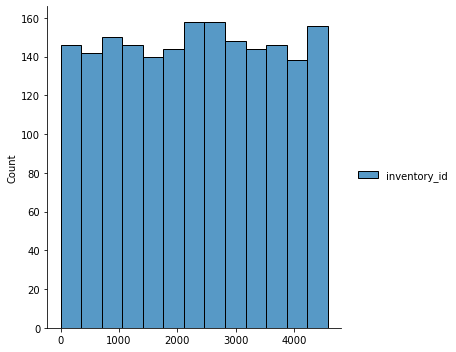

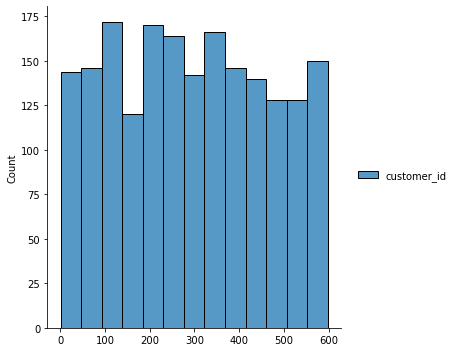

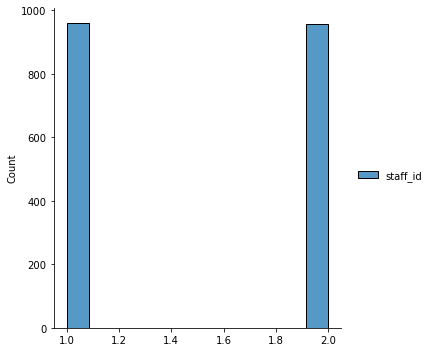

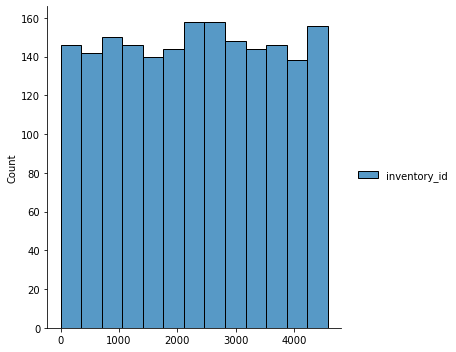

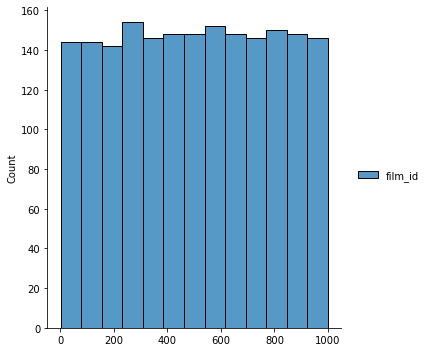

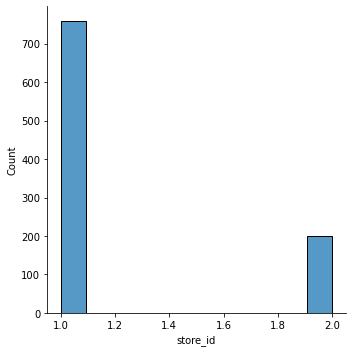

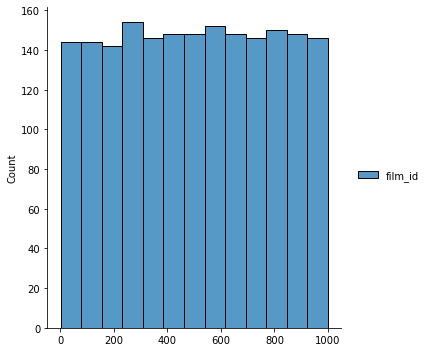

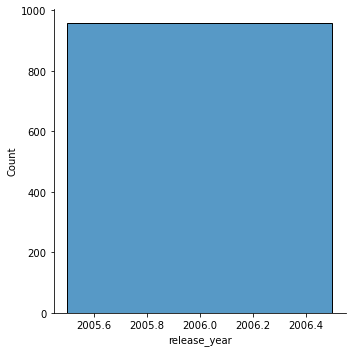

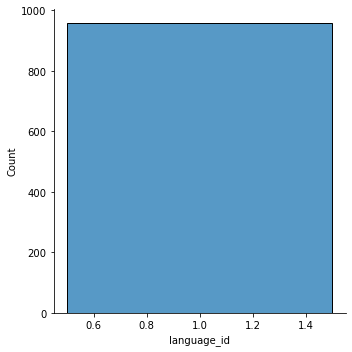

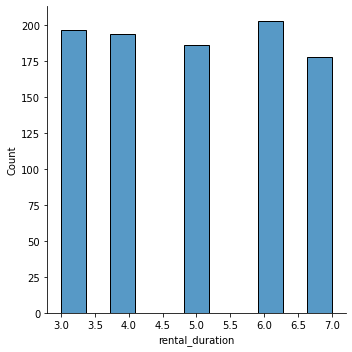

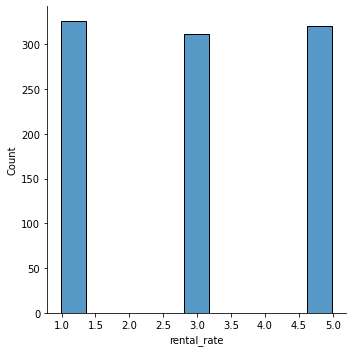

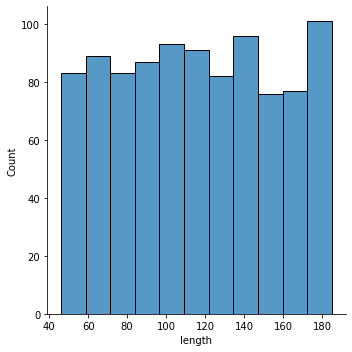

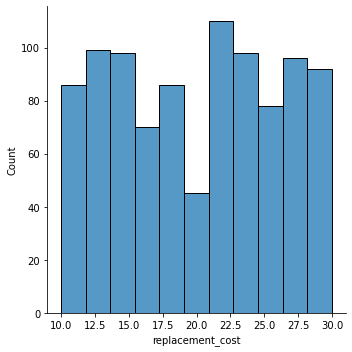

In [92]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

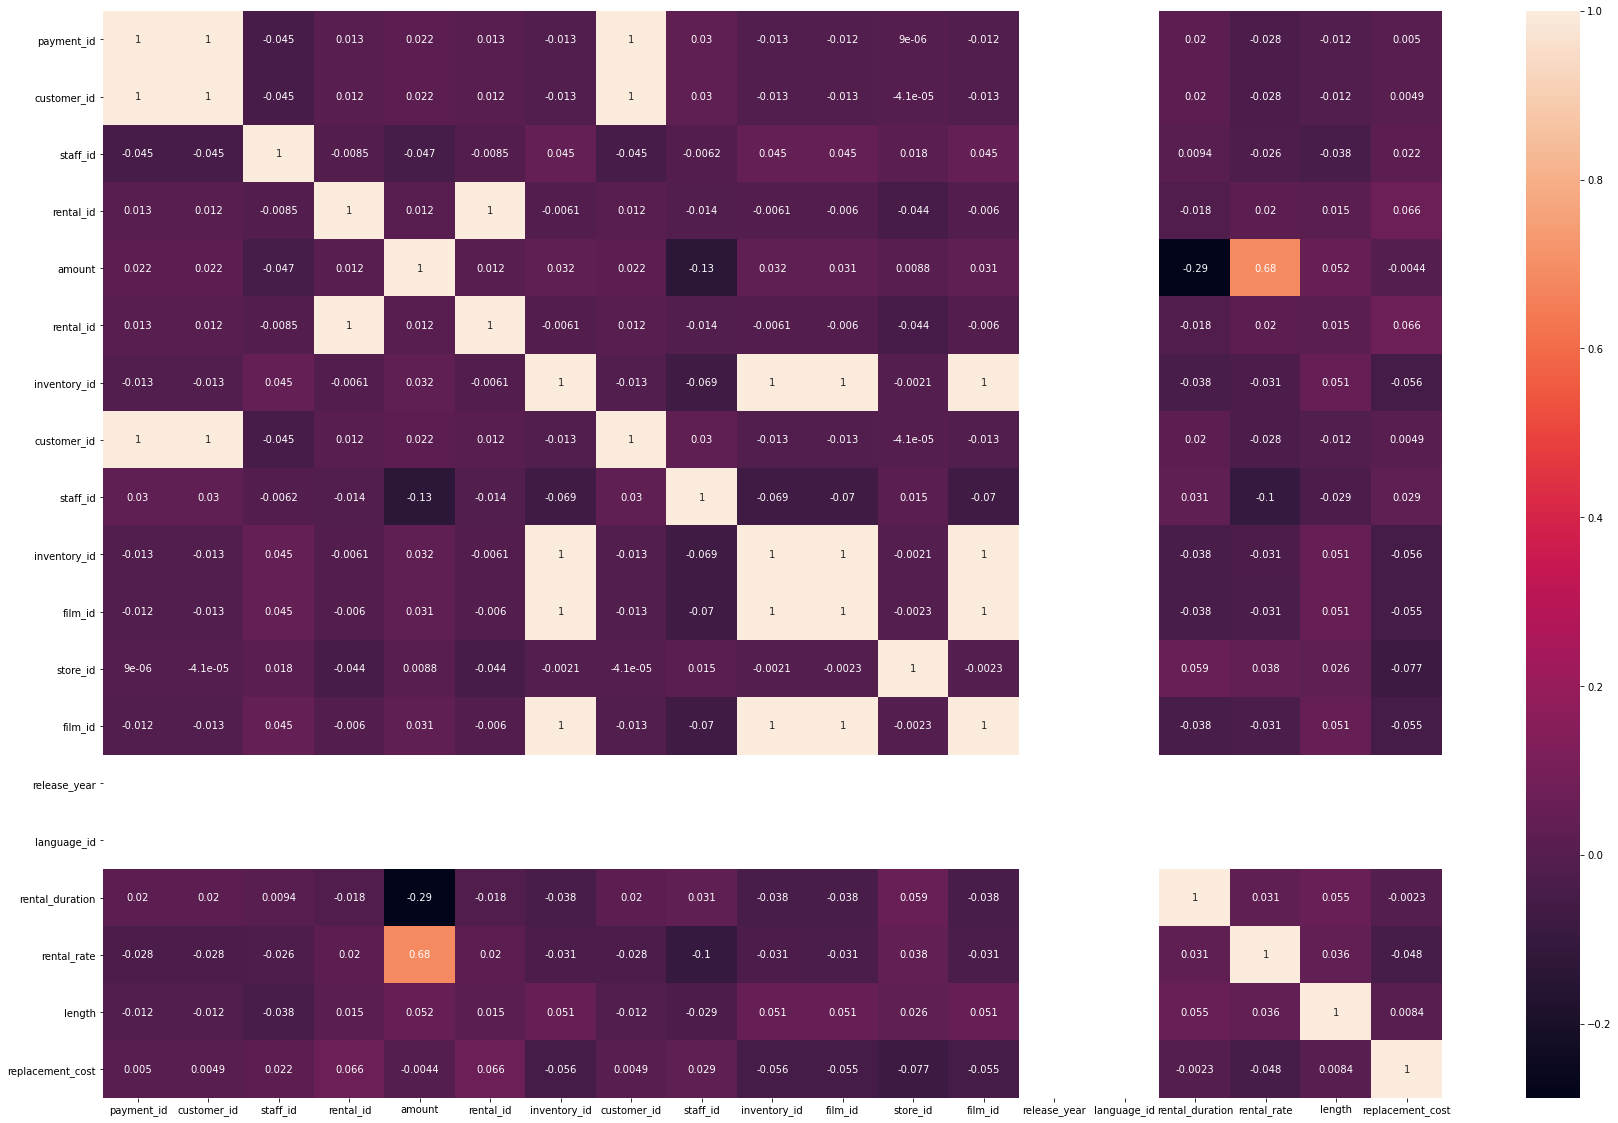

In [94]:
corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [95]:
X = np.concatenate([x_normalized, encoded], axis=1)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [102]:
predictions  = model.predict(X_test)
predictions.shape

(192,)

### 6- Evaluate the results (calculate the score of the model)

In [104]:
y_test.value_counts()

65.88     3
55.86     2
46.91     2
86.84     2
16.90     2
         ..
66.88     1
67.76     1
44.90     1
15.94     1
116.67    1
Name: total_sales, Length: 186, dtype: int64

In [105]:
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(-0.058803047884618875, 40.50018050065798, 1640.264620585877)

In [106]:
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

(-0.058803047884618875, 40.50018050065798, 1640.264620585877)

In [107]:
mse = mean_squared_error(y_test, predictions)
print(mse)

1640.264620585877


In [108]:
rmse = math.sqrt(mse)
print(rmse)

40.50018050065798


In [109]:
r2 = r2_score(y_test, predictions)
print(r2)

-0.058803047884618875


In [110]:
n = len(X_test)
p = X_test.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
print(adj_r2)

1.074431866818536
